In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm

import biosppy.signals
import pickle


# Retrieve Data

In [6]:
##  retrieve tensors ##
file = open('tensor_dump.pkl', 'rb')
raw_data_to_tensor = pickle.load(file)
amplitude_data_to_tensor  = pickle.load(file)
muscles_to_tensor = pickle.load(file)
elecs_to_tensor = pickle.load(file)

file.close()

In [7]:
## retrieve muscle and elec names

df_electrodes = pd.read_csv("df_electrodes.csv")
df_muscles= pd.read_csv("df_muscles.csv")

# Set Functions

## Given a muscle name the data tensor and amplitudes tensor is returned

In [8]:
## Make a function that given a muscle name, returns the data tensor and amplitudes tensor related to this muscle. ##
def return_data_for_muscle(muscle_name): # Input muscle_name Eg. "Vlat"
    """
    This function does this
    Parameters:
    - muscle_name String the name of the muscle 
    - 
    - 
    Returns:
    tuple with:
    -
    """
    # return(data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr) 
    # get:
    #raw data for specific muscle
    #amplitdue data for specific muscle
    #muscle_nr

    muscle_nr=df_muscles.index.where(df_muscles.muscle_name==muscle_name).dropna().astype(int)[0]
    data_tensor_muscle_i=raw_data_to_tensor[:,muscle_nr,:,:,:] #returns a tensor of size([16, 32, 11, 1404])
    amplitude_tensor_muslce_i=amplitude_data_to_tensor[:, muscle_nr, :] #returns a tensor of size([16, 32])
    print(f"will return all raw data for {muscle_nr}: {muscle_name}, and the amplitude data")
 
    return(data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr) 

   

In [ ]:
## check definition
data_tensor_muscle_i,amplitude_tensor_muslce_i =return_data_for_muscle("RRF")
# print(data_tensor_muscle_i.size())
print(amplitude_tensor_muslce_i[0][0])
# print(data_tensor_muscle_i[0]) #torch.Size([32, 11, 1404])

will return all raw data for 12 :RRF, and the amplitude data
tensor(nan)


## Given the muscle the maximum EMG value within the data is returned

In [28]:
# Make a function that finds for each muscle the maximum EMG value within the data, 
# saves the indeces and plots the trial with max emg value

def find_max_emg(muscle_name): # Input muscle_name Eg. "Vlat"
    # return int(elec_of_max_value), max_value, int(amp_ind_max_value)
    # get:
   
    #elec, amp, trial_nr of max emg value
    #max emg value
    #plot of trial with max emg

    elec_list=[]
    max_list=[]
    amp_index=[]
    trial_index=[]
    data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr =return_data_for_muscle(muscle_name)
    for elec in range (len(amplitude_data_to_tensor[:, 0, 0])): #loop through all the elecs

        # extract indeces where theres data for the amplitudes 
        df=pd.DataFrame(amplitude_tensor_muslce_i[elec, :])
        df=df.notna()
        idx_list=[]
        for idx  in range(len(df[0])):
            if df[0][idx] == True:
                idx_list.append(idx) # List with indeces for notna

        
 
        for amp_ind in idx_list:
            for trial in range(len(data_tensor_muscle_i[0, 0, :, 0])):
                if torch.isnan(data_tensor_muscle_i[elec, amp_ind, trial, 0])==False:
                    max=np.nanmax(data_tensor_muscle_i[elec, amp_ind, trial, :])

                    
                    max_list.append(max)
                    elec_list.append(elec)
                    amp_index.append(amp_ind)
                    trial_index.append(trial)
    
    #Save all the info in a df
    d = {'elec': elec_list, 'max_emg_value': max_list, "amplitude_ind": amp_index, "trial_index": trial_index}
    df = pd.DataFrame(data=d)
    
   #Get the max emg value for the muscle, and indeces 
    max_value=np.max(df["max_emg_value"])
    ind = np.where(df["max_emg_value"] == (np.max(df["max_emg_value"])))
    elec_of_max_value=df["elec"].iloc[ind[0][0]]
    amp_ind_max_value=df["amplitude_ind"].iloc[ind[0][0]]
    trial_ind_max_value=df["trial_index"].iloc[ind[0][0]]
    print(f"For muscle({muscle_nr}) {muscle_name} max EMG Value:{max_value} with electrode {int(elec_of_max_value)}, amplitude: {int(amp_ind_max_value)} and trial_nr:{trial_ind_max_value}")

    #Plot the trial with max emg
    plt.title(f"For muscle ({muscle_nr}) {muscle_name}, max emg signal:{max_value} was found in electrode: {int(elec_of_max_value)}, amplitude: {int(amp_ind_max_value)} and trial: {trial_ind_max_value}")
    plt.xlabel("Time")
    plt.plot(data_tensor_muscle_i[elec_of_max_value,amp_ind_max_value,trial_ind_max_value,:])

    return int(elec_of_max_value), max_value, int(amp_ind_max_value), int(trial_ind_max_value)



will return all raw data for 12: RRF, and the amplitude data
For muscle(12) RRF max EMG Value:3.583035469055176 with electrode 12, amplitude: 21 and trial_nr:4


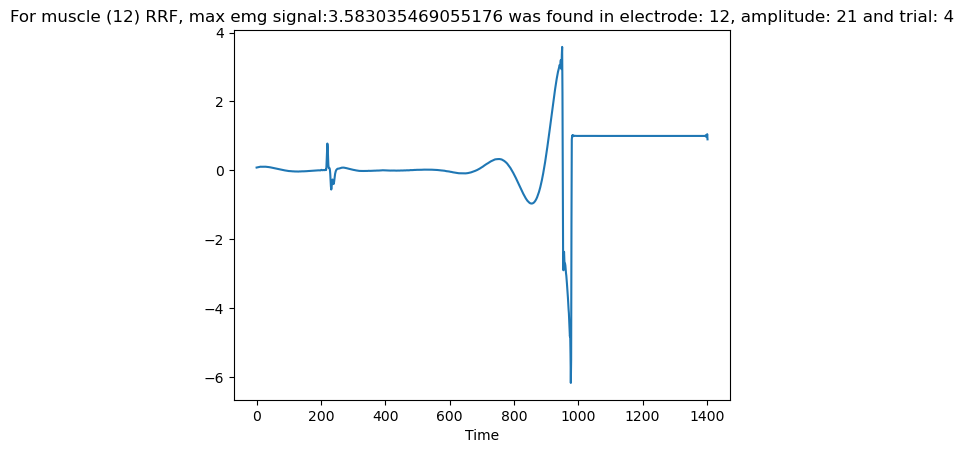

In [29]:
## Check function
elec_of_max_value, max_value, amp_ind_max_value, trial_ind_max_value=find_max_emg("RRF")



## Make a function that receives a single EMG time series and computes its peak-to-peak time series.

### Some tryouts with biosppy

In [342]:
# find window with emg values for a time series

# Determine onsets of EMG pulses. # Skips corrupted signal parts.??

# Parameters:	
# signal (array) – Input filtered EMG signal.
# sampling_rate (int, float, optional) – Sampling frequency (Hz).
# size (float, optional) – Detection window size (seconds).
# threshold (float, optional) – Detection threshold.
# Returns:	
# onsets (array) – Indices of EMG pulse onsets.

# biosppy.signals.emg.find_onsets(signal=raw_data_to_tensor[12,12,21,4,:], sampling_rate=1000.0, size=0.25, threshold=None) 
biosppy.signals.emg.find_onsets(signal=raw_data_to_tensor[12,12,21,4,:]) 


ReturnTuple(onsets=array([], dtype=int64))

In [348]:
np.array(raw_data_to_tensor[12,12,21,4,:])


array([0.08238404, 0.0846118 , 0.08438362, ..., 1.0508273 , 0.90098244,
              nan], dtype=float32)

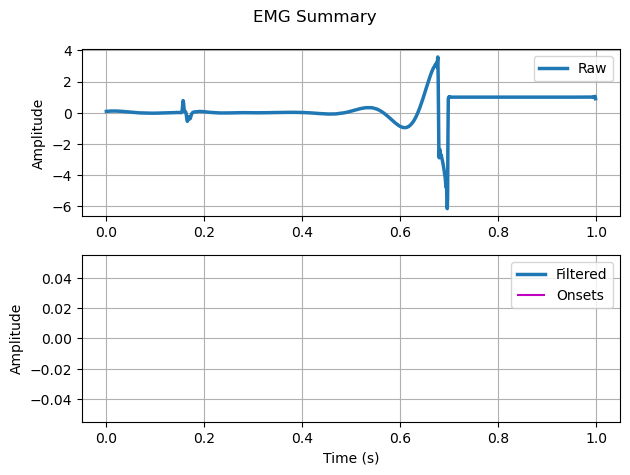

ReturnTuple(ts=array([0.00000000e+00, 7.12250712e-04, 1.42450142e-03, ...,
       9.97863248e-01, 9.98575499e-01, 9.99287749e-01]), filtered=array([nan, nan, nan, ..., nan, nan, nan]), onsets=array([], dtype=int64))

In [355]:

# Process a raw EMG signal and extract relevant signal features using default parameters. ??

# Parameters:	
# signal (array) – Raw EMG signal.
# sampling_rate (int, float, optional) – Sampling frequency (Hz).
# show (bool, optional) – If True, show a summary plot.
# Returns:	
# ts (array) – Signal time axis reference (seconds).
# filtered (array) – Filtered EMG signal.
# onsets (array) – Indices of EMG pulse onsets.


biosppy.signals.emg.emg(signal=np.array(raw_data_to_tensor[12,12,21,4,:]), sampling_rate=1404, show=True)
# biosppy.signals.emg.emg(signal=np.array(raw_data_to_tensor[12,12,21,4,:])) 

### Find amount of TPs for a window

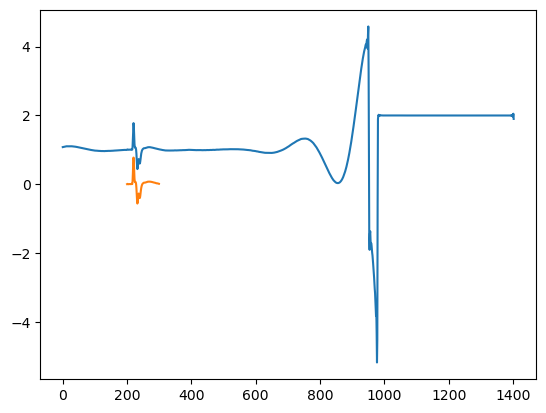

In [366]:
## Manually find how many TP are in a window
    # for now take 100

offset=1
init_art=200
end_art= 300
time_array_original=np.arange(0,len(raw_data_to_tensor[12,12,21,4,:]))
time_array_artifact=np.arange(init_art, end_art)
time_array = np.arange(1,1404+1)
plt.plot(time_array_original, np.array(raw_data_to_tensor[12,12,21,4,:])+offset)
plt.plot(time_array_artifact, np.array(raw_data_to_tensor[12,12,21,4,:][init_art:end_art ]))

### Find Peak to peak for TS and plot results

In [42]:
#4. Make a function that receives a single EMG time series and computes its peak-to-peak time series.
# For now we compute 
#what about elec?
def find_peak_to_peak_from_TS(EMG_time_series, window_size): #raw_data_to_tensor[12,12,21,4,:]
    peak_to_peak_values=[]
    
    windows_per_trial=EMG_time_series.unfold(0, window_size, 1)

    for window in windows_per_trial:
        max_y=np.nanmax(window)
        min_y=np.nanmin(window)
        peak_to_peak_values.append(max_y-min_y)
    
    # plt.plot(raw_data_to_tensor[12,12,21,4,:]+1, "Time series")
    # plt.plot(peak_to_peak_values, label="Peak to peak analysis of time series")
    # plt.show()
    figure, axis = plt.subplots(1, 2)
    axis[0].plot(EMG_time_series)
    
    axis[0].set(ylabel='EMG response')
    axis[0].set_title("Time series")
   
   # For peak to peak
    axis[1].plot(peak_to_peak_values)
    axis[1].set( ylabel='Peak-to_peak value')
    axis[1].yaxis.set_label_position("right")
    axis[1].yaxis.tick_right()
    axis[1].set_title("Peak to peak analysis of time series")
    plt.show()
    




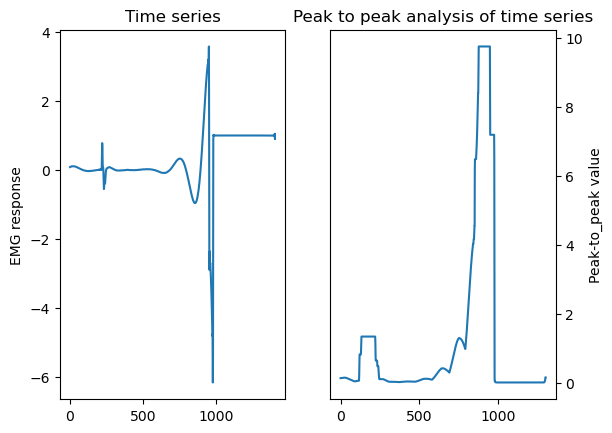

In [43]:
find_peak_to_peak_from_TS(raw_data_to_tensor[12,12,21,4,:], 100)

### Combine

In [44]:

def find_peak_to_peak_from_max_emg(muscle_name, window_size): # Input muscle_name Eg. "Vlat"
    data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr=return_data_for_muscle(muscle_name)
    elec_of_max_value, max_value, amp_ind_max_value, trial_ind_max_value=find_max_emg(muscle_name) # Input muscle_name Eg. "Vlat"
    find_peak_to_peak_from_TS(data_tensor_muscle_i[elec_of_max_value,amp_ind_max_value, trial_ind_max_value, : ], window_size)


   
    

will return all raw data for 4: LSol, and the amplitude data
will return all raw data for 4: LSol, and the amplitude data
For muscle(4) LSol max EMG Value:3.1386048793792725 with electrode 4, amplitude: 2 and trial_nr:0


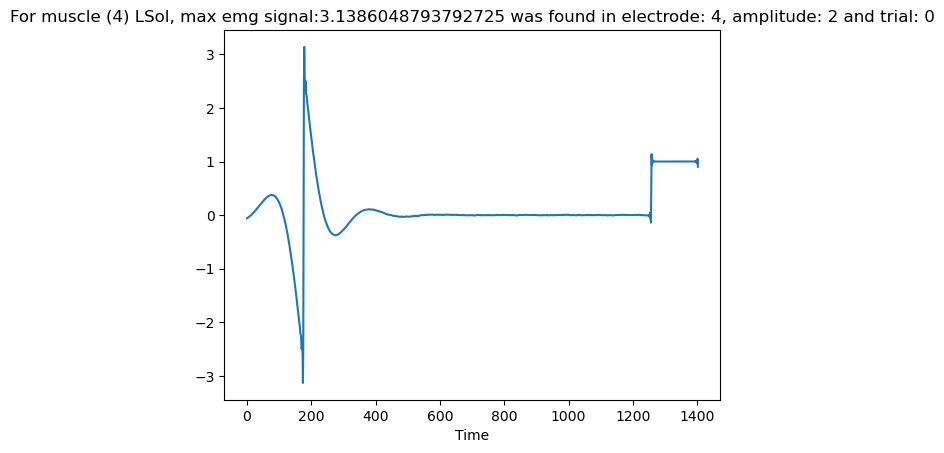

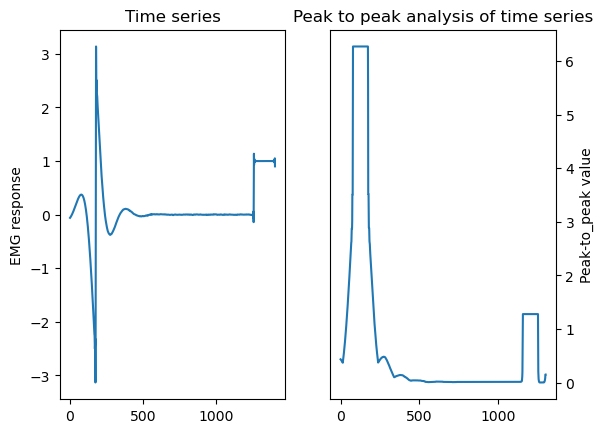

In [49]:

find_peak_to_peak_from_max_emg("LSol", 100)

In [40]:
print(df_muscles)

    Unnamed: 0 muscle_name
0            0         LST
1            1         RST
2            2         LTA
3            3         LMG
4            4        LSol
5            5       LVLat
6            6         LRF
7            7         LIl
8            8        RSol
9            9         RMG
10          10         RTA
11          11       RVLat
12          12         RRF
13          13         RIl


# Run analysis

In [ ]:

## 2.For every window find max pos and min neg



time_array_trial=np.arange(0, len(raw_data_to_tensor[12,12,21,4,:]))

peak_to_peak_value=[]

for window in range(len(windows_per_trial)):
# for window in [0]:
    #start point of window must alway shift
    start_point=np.where(raw_data_to_tensor[12,12,21,4,:] == windows_per_trial[window][0])[0][0]
    time_array_window=np.arange(start_point, start_point +len(windows_per_trial[0]))
    

    max_y=np.nanmax(windows_per_trial[window])
    # max_x=np.where(windows_per_trial[window] == max_y)[0][0]
    max_x=np.where(raw_data_to_tensor[12,12,21,4,:] == max_y)[0][0]
    min_y=np.nanmin(windows_per_trial[window])
    # min_x=np.where(windows_per_trial[window] == min_y)[0][0]
    min_x=np.where(raw_data_to_tensor[12,12,21,4,:] == min_y)[0][0]
    peak_to_peak_value.append(max_y-min_y)
    plt.title(f"Peak to peak value window: {window}; {peak_to_peak_value[window]}")
    plt.xlabel("EMG response")
    plt.ylabel("Time")
    plt.plot(time_array_window, windows_per_trial[window], label="window of trial")
    plt.plot(time_array_trial, np.array(raw_data_to_tensor[12,12,21,4,:])+ 1, label="total trial")
    plt.plot(max_x,max_y, 'r+', label= "max value of window")
    plt.plot(min_x,min_y, 'ro', label= "min value of window")
    plt.legend()
    
    plt.show()

In [50]:
amplitude_data_to_tensor[4,5,:]
# raw_data_to_tensor[4,5,3,:,:]

tensor([   nan,    nan, 0.8000,    nan,    nan,    nan,    nan,    nan, 1.4000,
           nan, 1.6000,    nan, 1.8000,    nan, 2.0000,    nan, 2.2000,    nan,
        2.4000,    nan, 2.6000,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan])